In [20]:
import os
from dotenv import load_dotenv

load_dotenv()
HF_TOKEN = os.getenv('HF')

garnt_dir = '../voice_cloning/source_samples/garnt/'
connor_dir = '../voice_cloning/source_samples/connor/'
joey_dir = '../voice_cloning/source_samples/joey/'

In [23]:
files = []
for d in [garnt_dir, connor_dir, joey_dir]:
    fnames = os.listdir(d)
    for fname in fnames:
        files.append(d + fname)
files

['../voice_cloning/source_samples/garnt/garnt_long-01.wav',
 '../voice_cloning/source_samples/garnt/garnt_long-02.wav',
 '../voice_cloning/source_samples/garnt/garnt_long-03.wav',
 '../voice_cloning/source_samples/garnt/garnt_long-04.wav',
 '../voice_cloning/source_samples/connor/connor_long-01.wav',
 '../voice_cloning/source_samples/connor/connor_long-02.wav',
 '../voice_cloning/source_samples/connor/connor_long-03.wav',
 '../voice_cloning/source_samples/connor/connor_long-04.wav',
 '../voice_cloning/source_samples/joey/joey_clean.wav',
 '../voice_cloning/source_samples/joey/joey_long-01.wav',
 '../voice_cloning/source_samples/joey/joey_long-02.wav',
 '../voice_cloning/source_samples/joey/joey_long-03.wav',
 '../voice_cloning/source_samples/joey/joey_long-04.wav']

In [19]:
from pyannote.audio import Model, Inference
import torch

model = Model.from_pretrained("pyannote/embedding", use_auth_token=HF_TOKEN)
model.to(torch.device("cuda"))

inference = Inference(model, window="whole")

Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\Paarth Tandon\.cache\torch\pyannote\models--pyannote--embedding\snapshots\c6335d8f1cd77b30084387468a6cf26fea90009b\pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\Paarth Tandon\.cache\torch\pyannote\models--pyannote--embedding\snapshots\c6335d8f1cd77b30084387468a6cf26fea90009b\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.1.1+cu121. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.1.1+cu121. Bad things might happen unless you revert torch to 1.x.


In [28]:
embeddings = {}

for fn in files:
    embeddings[fn.split('/')[-1]] = inference(fn)

In [30]:
from scipy.spatial.distance import cdist

comparison_results = {}

for file1, emb1 in embeddings.items():
    for file2, emb2 in embeddings.items():
        if file1 != file2:
            cosine_distance = cdist([emb1], [emb2], metric="cosine")[0,0]
            comparison_results[(file1, file2)] = cosine_distance

comparison_results

{('garnt_long-01.wav', 'garnt_long-02.wav'): 0.1755100271219069,
 ('garnt_long-01.wav', 'garnt_long-03.wav'): 0.20391639783433524,
 ('garnt_long-01.wav', 'garnt_long-04.wav'): 0.18413785010572714,
 ('garnt_long-01.wav', 'connor_long-01.wav'): 0.7935265705778961,
 ('garnt_long-01.wav', 'connor_long-02.wav'): 0.7678593279593166,
 ('garnt_long-01.wav', 'connor_long-03.wav'): 0.8190540198077412,
 ('garnt_long-01.wav', 'connor_long-04.wav'): 0.7906271090574547,
 ('garnt_long-01.wav', 'joey_clean.wav'): 0.7855187230171831,
 ('garnt_long-01.wav', 'joey_long-01.wav'): 0.7408602531344535,
 ('garnt_long-01.wav', 'joey_long-02.wav'): 0.7310572593714748,
 ('garnt_long-01.wav', 'joey_long-03.wav'): 0.7531499418213454,
 ('garnt_long-01.wav', 'joey_long-04.wav'): 0.7218972558652996,
 ('garnt_long-02.wav', 'garnt_long-01.wav'): 0.1755100271219069,
 ('garnt_long-02.wav', 'garnt_long-03.wav'): 0.18320437154620084,
 ('garnt_long-02.wav', 'garnt_long-04.wav'): 0.2192733932629125,
 ('garnt_long-02.wav', 'c

In [33]:
transformed_dict = {}
for (file1, file2), distance in comparison_results.items():
    # Extracting the names from the file names
    name1 = file1.split('_')[0]
    name2 = file2.split('_')[0]

    # Creating a key for each unique name pair
    name_pair = tuple(sorted([name1, name2]))

    # Appending the distance to the list of distances for each name pair
    if name_pair not in transformed_dict:
        transformed_dict[name_pair] = []
    transformed_dict[name_pair].append(distance)

transformed_dict.keys()

dict_keys([('garnt', 'garnt'), ('connor', 'garnt'), ('garnt', 'joey'), ('connor', 'connor'), ('connor', 'joey'), ('joey', 'joey')])

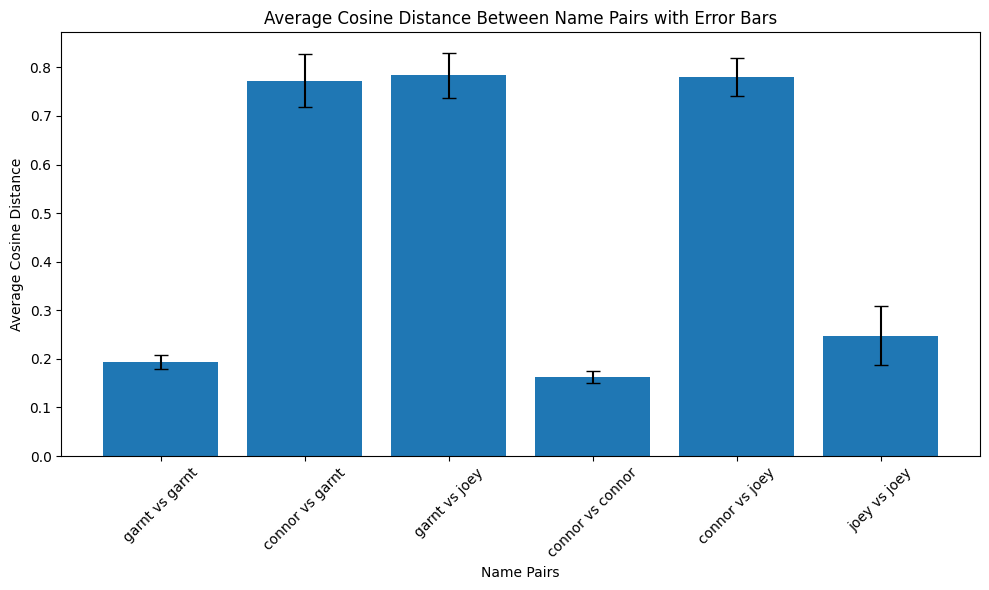

In [35]:
import numpy as np
import matplotlib.pyplot as plt

names = []
means = []
errors = []

for name_pair, distances in transformed_dict.items():
    names.append(' vs '.join(name_pair))
    means.append(np.mean(distances))
    errors.append(np.std(distances))

# Plotting the bar graph with error bars
plt.figure(figsize=(10, 6))
plt.bar(names, means, yerr=errors, capsize=5)
plt.xlabel('Name Pairs')
plt.ylabel('Average Cosine Distance')
plt.title('Average Cosine Distance Between Name Pairs with Error Bars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()